# Filler Word Detection Model

## Data synthesis: Creating a speech dataset
### 1.1 - Listening to the data

Importing Libraries...

In [139]:
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import random
import sys
import io
import os
import glob
import IPython
import wave
import pylab
from tf_utils import *
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

# Import files for trigger-word detection model
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Declaring Environment Variables...

In [140]:
POSITIVE_DIRECTORY = "./raw_data/positive_data/"
BACKGROUND_DIRECTORY = "./raw_data/background_data/"
NEGATIVES_DIRECTORY = "./raw_data/google_dataset/"
NEGATIVES_TRUNCATED_DIRECTORY = "./raw_data/google_dataset_truncated/"
AUDIO_EXAMPLES_DIRECTORY = "./audio_examples/"
AUDIO_IGNORED_EXAMPLES_DIRECTORY = "./audio_ignored_examples/"
POSITIVE_EXAMPLE = "jh_1.wav"
AUDIO_EXAMPLE = "example_train.wav"
STUB_TRAIN_DIRECTORY = "./stub_data/XY_Train/"
STUB_DEV_DIRECTORY = "./stub_data/XY_Dev/"
STUB_MODEL = "./stub_data/models/tr_model.h5"

Loading raw audio files...

In [4]:
play(AudioSegment.from_file(POSITIVE_DIRECTORY + POSITIVE_EXAMPLE))

## [SKIP to 1.3.1 to generate training examples] 1.2 - From audio recordings to spectograms

In [5]:
play(AudioSegment.from_file(AUDIO_EXAMPLES_DIRECTORY + AUDIO_EXAMPLE, format="wav"))

In [6]:
sample_rate, samples = wavfile.read(AUDIO_EXAMPLES_DIRECTORY + AUDIO_EXAMPLE)
frequencies, times, x = signal.spectrogram(samples, sample_rate)

In [7]:
# _, data = wavfile.read(AUDIO_EXAMPLES_DIRECTORY + AUDIO_EXAMPLE)
# print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in input after spectrogram (129, 2142)


In [8]:
Tx = 2142 # The number of time steps input to the model from the spectrogram
n_freq = 129 # Number of frequencies input to the model at each time step of the spectrogram


In [9]:
Ty = 532 # The number of time steps in the output of our model

## 1.3 - Generating a single training example
Note that 1.2 is skipped because we need to first have a training example before we can graph its spectogram.

In [10]:
# Load raw audio files for speech synthesis
def load_raw_audio(positiveDirectory, backgroundDirectory, negativesDirectory):
    BACKGROUND_DIRECTORY_IN_GOOGLE_DATASET = "_background_noise_/"
    positives = []
    backgrounds = []
    negatives = []
    for filename in os.listdir(positiveDirectory):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav(positiveDirectory + filename)
            positives.append(activate)
    for filename in os.listdir(backgroundDirectory):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav(backgroundDirectory + filename)
            backgrounds.append(background)
    for directory in os.listdir(negativesDirectory):
        if os.path.isdir(os.path.join(negativesDirectory, directory)) and directory != BACKGROUND_DIRECTORY_IN_GOOGLE_DATASET: # Excludes background directory in google dataset
            for filename in os.listdir(negativesDirectory + directory):
                if filename.endswith("wav"):
                    negative = AudioSegment.from_wav(negativesDirectory + directory + "/" + filename)
                    negatives.append(negative)
    return positives, negatives, backgrounds



In [11]:
# Load audio segments using pydub 
# positives, negatives, backgrounds = load_raw_audio(POSITIVE_DIRECTORY, BACKGROUND_DIRECTORY, NEGATIVES_DIRECTORY)  # Actual dataset. Use this for production.
positives, negatives, backgrounds = load_raw_audio(POSITIVE_DIRECTORY, BACKGROUND_DIRECTORY, NEGATIVES_TRUNCATED_DIRECTORY) # Truncated negative dataset. Use this to save time.

assert len(backgrounds[0]) == 10000, "Should be 10,000 since it is a 10s clip"
assert 0 < len(positives[0]) < 2000, "Maybe around 1000, since a positive audio clip is usually around 1 sec (but varies a lot)"
assert 0 < len(negatives[0]) < 2000, "Maybe around 1000, since a negative audio clip is usually around 1 sec (but varies a lot)"

\[OPTIONAL\] Playing audio clips...

In [12]:
# play(backgrounds[0])
# play(positives[0])
# play(negatives[0])

In [13]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [14]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###

    return overlap

overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])

assert overlap1 == False, "Should not overlap."
assert overlap2 == True, "Should overlap."

In [15]:

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [16]:
audio_clip, segment_time = insert_audio_clip(backgrounds[0], positives[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
play(AudioSegment.from_file("insert_test.wav", format="wav"))

Segment Time:  (5935, 7652)


In [17]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y
    

IndexError: index 1333 is out of bounds for axis 0 with size 532

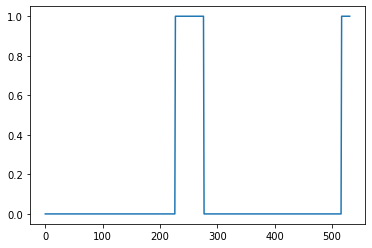

In [18]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [ ]:
def create_training_example(background, positives, negatives):
    """
    Creates a training example with a given background, positives, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    positives -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make background quieter - commented out as background is already very soft
    # background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "positives" recordings
    number_of_positives = np.random.randint(0, 5)
    random_indices = np.random.randint(len(positives), size=number_of_positives)
    random_positives = [positives[i] for i in random_indices]
    
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_positives:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip 
    # background = match_target_amplitude(background, -20.0)

    # Export new training example 
    background = background.set_channels(1)
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")

    sample_rate, samples = wavfile.read("train.wav")
    frequencies, times, x = signal.spectrogram(samples, sample_rate)
    
    return frequencies, times, x, y

In [ ]:
frequencies, times, x, y = create_training_example(backgrounds[0], positives, negatives)

In [ ]:
play(AudioSegment.from_file("train.wav", format="wav"))

In [ ]:
# Note that the x-axis is not in 10^-2 seconds. It's 10 seconds discretised to 1375 units. (read 1.2)
plt.plot(y[0])

\[Optional\] Plotting spectrogram...

In [ ]:
plt.pcolormesh(times, frequencies, np.log(x))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## 1.3.1

Instead of loading the entire dataset, only the names of files and audios are loaded. They are stored in a python dictionary. Each time a random audio is to be selected, randomly choose a name from the dictionary and look for corresponding audio. 

In [141]:
Tx = 5511 # Based on created training example
n_freq = 129 # Based on created training example
Ty = 1375 # Based on model.summary() in 1.4 with shape := (Tx, n_freq)

In [142]:
NEGATIVES_FILENAMES = [name for name in os.listdir(NEGATIVES_DIRECTORY) if os.path.isdir(os.path.join(NEGATIVES_DIRECTORY, name)) 
                       and '_' not in name]
NEGATIVES_AUDIONAMES = {}
for file in NEGATIVES_FILENAMES:
    NEGATIVES_AUDIONAMES[file] = [name for name in os.listdir(NEGATIVES_DIRECTORY + file + "/") if name.endswith("wav")]

In [143]:
def random_element(lst, n):
    """
    Assume n <= len(lst)
    Return n elements randomly from lst
    """
    random_index = np.random.randint(len(lst), size = n)
    return [lst[i] for i in random_index]

def random_negatives(negative_audionames):
    """
    Given a python dictionary of all audio names in negative files
    Return a list of 0-2 randomly selected negative audios
    """
    # determine number of negatives to generate: 0-2
    num_neg = np.random.randint(0, 3)
    if num_neg == 0:
        return []
    # find 0-2 random file
    random_files = random_element(list(negative_audionames.keys()), num_neg)
    output = []
    for file in random_files:
        audio_names = negative_audionames[file]
        # from each file generate a random audio
        random_audio = random_element(audio_names, 1)[0]
        # load the chosen audio
        global NEGATIVES_DIRECTORY
        link = NEGATIVES_DIRECTORY + file + "/" + random_audio
        audio = AudioSegment.from_wav(link)
        output.append(audio)
    return output

In [74]:
# Test case:
neg = random_negatives(NEGATIVES_AUDIONAMES)
if len(neg) > 0:
    play(neg[0])

Similarly for positive and background audios, the names of audios are loaded and stored in two lists. Each time a random audio is to be selected, randomly choose a name from the dictionary and look for corresponding audio. 

In [144]:
POSITIVES_AUDIONAMES = [name for name in os.listdir(POSITIVE_DIRECTORY) if name.endswith("wav")]
BACKGROUND_AUDIONAMES = [name for name in os.listdir(BACKGROUND_DIRECTORY) if name.endswith("wav")]

In [145]:
def random_positives(positives_audionames):
    """
    Given a list of positive audio names
    Return a list of 0-4 randomly selected positive audios
    """
    # determine number of positives to generate: 0-4
    num_pos = np.random.randint(0, 5)
    if num_pos == 0:
        return []
    # generate n random audios
    random_audios = random_element(positives_audionames, num_pos)
    output = []
    for name in random_audios:
        # load audio
        global POSITIVE_DIRECTORY
        link = POSITIVE_DIRECTORY + name
        audio = AudioSegment.from_wav(link)
        output.append(audio)
    return output

def random_background(background_audionames):
    """
    Given a list of background audio names
    Return a randomly selected background audio
    """
    # generate a random audio
    random_audio = random_element(background_audionames, 1)[0]
    # load audio
    global BACKGROUND_DIRECTORY
    link = BACKGROUND_DIRECTORY + random_audio
    return AudioSegment.from_wav(link)

In [77]:
# Test case 1:
pos = random_positives(POSITIVES_AUDIONAMES)
if len(pos) > 0:
    play(pos[0])
# Test case 2:
bg = random_background(BACKGROUND_AUDIONAMES)
play(bg)

Function cannot_insert to detect situation when no available time slot can be found.

In [146]:
def cannot_insert(audio_clip, previous_segments):
    """
    Check if it's impossible to insert an audio clip to the current background.
    """
    if len(previous_segments) == 0:
        return False
    segment_ms = len(audio_clip)
    start_end_points = [-1, 10001]
    for start, end in previous_segments:
        start_end_points.append(start)
        start_end_points.append(end)
    start_end_points.sort()
    for i in list(range(len(start_end_points)))[::2]:
        available_length = start_end_points[i+1] - start_end_points[i] - 1
        if available_length >= segment_ms:
            return False
    return True

In [148]:
# Test case
test_audio = AudioSegment.from_wav(POSITIVE_DIRECTORY + POSITIVE_EXAMPLE)
print(len(test_audio))
print(cannot_insert(test_audio, [(2071, 3000), (5072, 6000), (8072, 9000)])) # No available slot possible
print(cannot_insert(test_audio, [(1000, 2000), (3000, 4000)])) # Available slot present

2072
True
False


The create_training_example function is then modified to adapt to above changes.

In [206]:
def create_training_example(id):
    """
    Creates a training examples with a given background, positives, and negatives with id.
    
    Arguments:
    id -- an id is given such that the new files does not replace the previous files
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    global BACKGROUND_AUDIONAMES
    global POSITIVES_AUDIONAMES
    global NEGATIVES_AUDIONAMES
    
    background = random_background(BACKGROUND_AUDIONAMES)
    positives = random_positives(POSITIVES_AUDIONAMES)
    negatives = random_negatives(NEGATIVES_AUDIONAMES)
    
    # Make background quieter
    background = background - 20
    
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []    
    
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_positive in positives:
        if cannot_insert(random_positive, previous_segments):
            return create_training_example(id)
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_positive, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in negatives:
        if cannot_insert(random_negative, previous_segments):
            return create_training_example(id)
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)

    # Export new training example 
    background = background.set_channels(1)
    background = background.set_frame_rate(123000)
    
    TRAIN_PREFIX = "train_"
    file_handle = background.export(AUDIO_IGNORED_EXAMPLES_DIRECTORY + TRAIN_PREFIX + str(id) + ".wav", format="wav")
    # print("File (train_" + str(id) + ".wav) was saved in your directory.")

    sample_rate, samples = wavfile.read(AUDIO_IGNORED_EXAMPLES_DIRECTORY + TRAIN_PREFIX + str(id) +".wav")
    frequencies, times, x = signal.spectrogram(samples, sample_rate)
    
    return frequencies, times, x, y

In [207]:
# Test case:
frequencies, times, x, y = create_training_example(1)
IPython.display.Audio(AUDIO_IGNORED_EXAMPLES_DIRECTORY + "train_1.wav")

In [208]:
# Checking x and y shapes
print(x.shape)
print(y.shape)

(129, 5490)
(1, 1375)


In [209]:
def create_X_Y(size):
    i, X, Y = 1, [], []
    for i in range(size):
        frequencies, times, x, y = create_training_example(i)
        x = np.transpose(x)
        y = np.transpose(y)
        X.append(x)
        print(np.array(X).shape)
        Y.append(y)
    return (np.array(X), np.array(Y))

In [210]:
X, Y = create_X_Y(20)

(1, 5490, 129)
(2, 5490, 129)
(3, 5490, 129)
(4, 5490, 129)
(5, 5490, 129)
(6, 5490, 129)
(7, 5490, 129)
(8, 5490, 129)
(9, 5490, 129)
(10, 5490, 129)
(11, 5490, 129)
(12, 5490, 129)
(13, 5490, 129)
(14, 5490, 129)
(15, 5490, 129)
(16, 5490, 129)
(17, 5490, 129)
(18, 5490, 129)
(19, 5490, 129)
(20, 5490, 129)


In [180]:
X.shape, Y.shape

((20,), (20, 1375, 1))

In [97]:
np.save("./training_data/X_1.npy", X)
np.save("./training_data/Y_1.npy", Y)

In [212]:
# GRADED FUNCTION: model

def model(input_shape):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV Layer
    # CONV-1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch Normalization
    X = BatchNormalization()(X)
    # RelU activation
    X = Activation("relu")(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    
    # Step 2: First GRU Layer
    # GRU (use 128 units to return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second GRU Layer
    # GRU (use 128 units to return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    
    # Step 4: Time-distributed dense layer
    X = TimeDistributed(Dense(1, activation="sigmoid"))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

In [213]:
# Check the model returned by model() function
# Using stub data
Tx_stub = 5490
n_freq_stub = 129
model = model(input_shape = (Tx_stub, n_freq_stub))
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5490, 129)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1369, 196)         379456    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1369, 196)         784       
_________________________________________________________________
activation_2 (Activation)    (None, 1369, 196)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1369, 196)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 1369, 128)         124800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1369, 128)         0   

In [4]:
# Function to fit and further train the model
def model_train(model, X, Y):
    """
    Function to train the model further using Adam optimiser and binary 
    cross entropy loss.
    
    Arguments:
    model -- Model to train
    X -- X data to train on
    Y -- Y data to train on
    """
    
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    model.fit(X, Y, batch_size=5, epochs=1)

In [5]:
# Train the model on stubbed data downloaded from Coursera
model = load_model(STUB_MODEL)
X = np.load(STUB_TRAIN_DIRECTORY + "X.npy")
Y = np.load(STUB_TRAIN_DIRECTORY + "Y.npy")

model_train(model, X, Y)

NameError: name 'load_model' is not defined

In [ ]:
# Function to test the model on new data
def model_test(model, X_dev, Y_dev):
    loss, acc = model.evaluate(X_dev, Y_dev)
    print("Dev set accuracy = ", acc)

X_dev = np.load(STUB_DEV_DIRECTORY + "X_dev.npy")
Y_dev = np.load(STUB_DEV_DIRECTORY + "Y_dev.npy")

In [ ]:
model_test(model, X_dev, Y_dev)